In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Importing necessary packages
import os
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

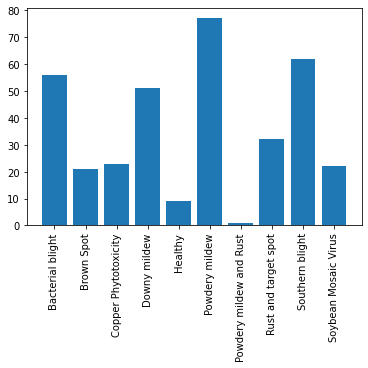

In [4]:
# Reading folders where each folder corresponds to each disease
dataset = '/content/gdrive/MyDrive/Colab Notebooks/Dataset/'
folders = os.listdir(dataset)
folders.sort()
# Count no.of images w.r.t each disease
img_count = {}
for folder in folders:
    cnt = len(os.listdir(dataset+folder+os.sep))
    img_count[folder] = cnt
# Plotting barplots of no.of leaf images w.r.t each disease
plt.bar(img_count.keys(), img_count.values())
plt.xticks(rotation='vertical')
plt.show()

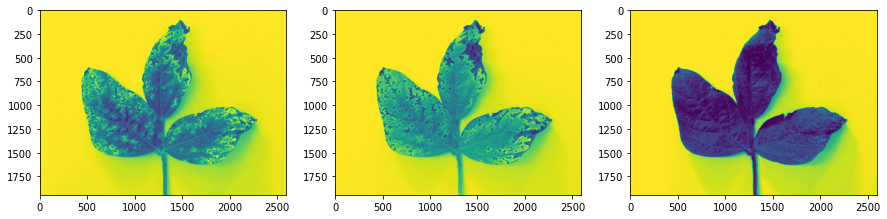

In [5]:
# Trying different color spaces to find best color channel.
image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/Dataset/Bacterial blight/Crestamento bacteriano (2).jpg')
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# RGB Channel
R = img_rgb[:, :, 0]
G = img_rgb[:, :, 1]
B = img_rgb[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(R)
ax[1].imshow(G)
ax[2].imshow(B)

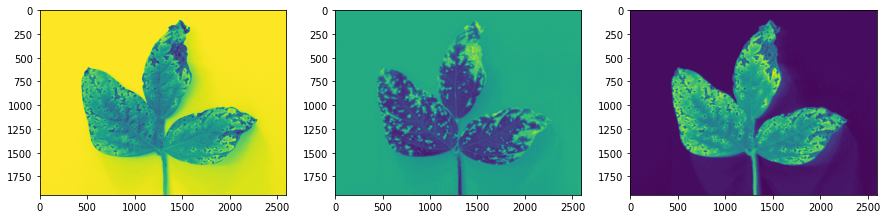

In [6]:
# Lab Color Space - https://en.wikipedia.org/wiki/CIELAB_color_space
L = img_lab[:, :, 0]
a = img_lab[:, :, 1]
b = img_lab[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(L)
ax[1].imshow(a)
ax[2].imshow(b)

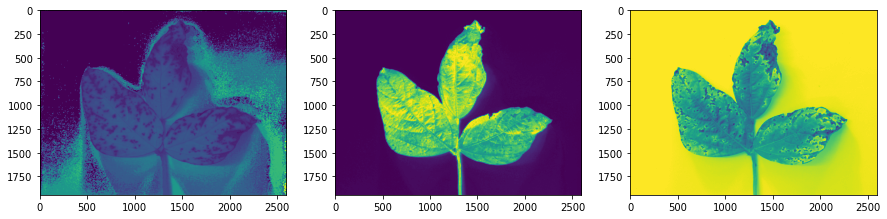

In [7]:
# HSV Color Space - https://en.wikipedia.org/wiki/HSL_and_HSV
H = img_hsv[:, :, 0]
S = img_hsv[:, :, 1]
V = img_hsv[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(H)
ax[1].imshow(S)
ax[2].imshow(V)

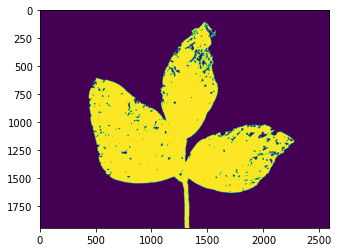

In [8]:
# K-means clustering in opencv - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
pixel_vals = b.flatten()
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Since we are interested in only actual leaf pixels, we choose 2 clusters
# one cluster for actual leaf pixels and other for unwanted background pixels.
K = 2
retval, labels, centers = cv2.kmeans(pixel_vals, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((b.shape))
pixel_labels = labels.reshape(img_lab.shape[0], img_lab.shape[1])
# displaying segmented image
plt.imshow(segmented_image)

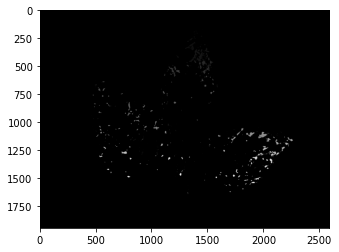

In [9]:
# Doing this, some unwanted pixels that are clustered in main cluster can be avoided.
# Ref - https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gac2718a64ade63475425558aa669a943a
pixel_labels = np.uint8(pixel_labels)
ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)
plt.imshow(components, cmap='gray')

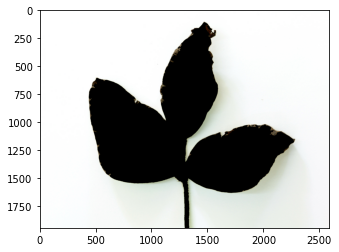

In [10]:
indices = []
for i in range(1, ret):
    row, col = np.where(components==i)
    indices.append(max(len(row), len(col)))
component = np.argmax(np.array(indices))
main_component = component+1   #indexing starts from 0, so we increment by 1 to get actual component index
# creating a mask and extracting pixels corresponding to cluster to which leaf belongs.
# 1 for actual leaf pixels and 0 for other pixels
mask = np.where(components==main_component, 1, 0)
B = image[:, :, 0]
G = image[:, :, 1]
R = image[:, :, 2]
# Extract only masked pixels
r = R*mask
g = G*mask
b = B*mask
final_img = np.dstack((r, g, b))
plt.imshow(final_img)

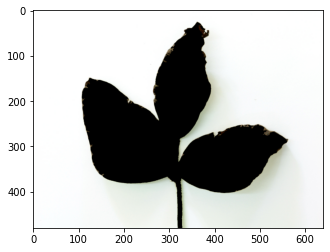

In [11]:
v_sum = np.sum(mask, axis=0)
h_sum = np.sum(mask, axis=1)
w = np.count_nonzero(v_sum)
h = np.count_nonzero(h_sum)
x_indices = np.where(v_sum != 0)
y_indices = np.where(h_sum != 0)
x = x_indices[0][0]
y = y_indices[0][0]
final_crop_img = final_img[y:y+h-1, x:x+w-1, :]
final_crop_img = np.uint8(final_crop_img)
img = cv2.resize(final_crop_img, (640,480), interpolation=cv2.INTER_AREA)
plt.imshow(img)

In [12]:
import keras
from keras import regularizers
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard
import warnings
warnings.filterwarnings('ignore')
import itertools
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
path = '/content/gdrive/MyDrive/Colab Notebooks/'
dataset = '/content/gdrive/MyDrive/Colab Notebooks/Dataset/'
folders = os.listdir(dataset)
folders.sort()
# Storing image data in csv file
img_names = []
img_array = []
labels = []
for folder in folders:
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()
    for img in imgs:
        im = cv2.imread(dataset+folder+os.sep+img)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_size = cv2.resize(im_rgb, (144, 144), interpolation=cv2.INTER_AREA)
        img_names.append(img)
        img_array.append(im_size)
        labels.append(folder)
df = pd.DataFrame({'Image ID': img_names, 'Class': labels})
df.to_csv(path+'Files-Original/soyabean_original.csv', index=False)
# Saving image data in numpy array format
X = np.asarray(img_array)
np.save(path+'Files-Original/imgs_original', X)

In [14]:
data = pd.read_csv(path+'Files-Original/soyabean_original.csv')
data.head()

,Image ID,Class
0,Crestamento bacteriano (1).jpg,Bacterial blight
1,Crestamento bacteriano (2).jpg,Bacterial blight
2,Crestamento bacteriano (3).jpg,Bacterial blight
3,DSC_0038.jpg,Bacterial blight
4,DSC_0039.jpg,Bacterial blight


In [16]:
# Mapping original class labels to integer values
# Ex: Bacterial Blight-0, Brown Spot-1, ..etc
labels = {}
val_cnt = 0
for folder in folders:
    labels[folder] = val_cnt
    val_cnt = val_cnt+1
X = np.load(path+'Files-Original/imgs_original.npy')
y = data['Class'].map(labels).values
data['Image Array'] = X.tolist()
data['Labels'] = y
data.head()

,Image ID,Class,Image Array,Labels
0,Crestamento bacteriano (1).jpg,Bacterial blight,"[[[254, 255, 255], [255, 255, 255], [255, 255,...",0
1,Crestamento bacteriano (2).jpg,Bacterial blight,"[[[254, 255, 255], [255, 255, 255], [255, 255,...",0
2,Crestamento bacteriano (3).jpg,Bacterial blight,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,DSC_0038.jpg,Bacterial blight,"[[[133, 132, 125], [132, 130, 124], [49, 54, 4...",0
4,DSC_0039.jpg,Bacterial blight,"[[[25, 31, 28], [11, 16, 8], [14, 17, 11], [26...",0


In [17]:
X = data.drop(['Image ID', 'Class', 'Labels'], axis=1)
y = data['Labels']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, random_state=1)
imbalance_train = X_tr.copy()
imbalance_train['Labels'] = y_tr
imbalance_train['Labels'].value_counts()

5    63
8    52
0    52
3    42
7    28
1    19
9    19
2    16
4     8
6     1
Name: Labels, dtype: int64

In [18]:
# Reference: upsampling in python-https://elitedatascience.com/imbalanced-classes
majority_class = imbalance_train[imbalance_train.Labels == 6]
# Upsampling for imbalance dataset in python
upsampled_classes = [majority_class]
minority_labels = [0,1,2,3,4,5,7,8,9]
for i in minority_labels:
    minority_class = imbalance_train[imbalance_train.Labels == i]
    minority_upsampled = resample(minority_class, replace = True,n_samples = majority_class.shape[0],random_state = 0)
    upsampled_classes.append(minority_upsampled)
train_upsampled = pd.concat(upsampled_classes)
train_shuffled = train_upsampled.sample(frac=1, random_state=0)
X_tr1 = train_shuffled['Image Array'].values
y_tr1 = train_shuffled['Labels'].values
y_train = keras.utils.np_utils.to_categorical(y_tr1, num_classes=10)
y_test = keras.utils.np_utils.to_categorical(y_te, num_classes=10)
train_X = X_tr1.tolist()
X_train = np.asarray(train_X)
X_te1 = X_te['Image Array'].values
test_X = X_te1.tolist()
X_test = np.asarray(test_X)
# Scaling pixel values - Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

In [21]:
# Performing Data Augmentation on training data
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
datagen.fit(X_train)
it_train = datagen.flow(X_train, y_train, batch_size=4)
steps = int(X_train.shape[0]/4)

In [22]:
# Model parameters
input_shape = (144, 144, 3)
num_classes = 10
# Saving model weights and other important parameters
# checkpoint = ModelCheckpoint(path+"Results/model_complex.h5", monitor="val_acc",mode="max", save_best_only=True, verbose=1)
# tensorboard = TensorBoard(log_dir=path+"Results/graph_complex", histogram_freq=4, batch_size=4,update_freq='epoch')
# callbacks = [checkpoint, tensorboard]
# model architecture
model1 = Sequential()
model1.add(Conv2D(32,(3,3),activation='relu',padding='same',strides=(2,2),kernel_initializer='he_normal',input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Flatten())
model1.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model1.add(Dense(num_classes, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()
# fitting the model on training data.
history = model1.fit(it_train,steps_per_epoch=3,epochs=5, validation_data=(X_test, y_test),verbose=1)
sns.set()
model1.save_weights(path+"Results/model_complex.h5")
#plt.plot(history.history['acc'], 'r')
#plt.plot(history.history['val_acc'], 'b')
#plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
#plt.show()
#plt.plot(history.history['loss'], 'r')
#plt.plot(history.history['val_loss'], 'b')
#plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
#plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 36, 36, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 36, 36, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 36, 36, 128)      

In [35]:
model1 = Sequential()
model1.add(Conv2D(32,(3,3),activation='relu',padding='same',strides=(2,2),kernel_initializer='he_normal',input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Flatten())
model1.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model1.add(Dense(num_classes, activation='softmax'))
model1.load_weights(path+'Results/model_complex.h5')
y_pred_tr = model1.predict(X_train)
y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)
train_acc = accuracy_score(y_tr2, y_pred_tr)
y_pred = model1.predict(X_test)
y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)
test_acc = accuracy_score(y_te2, y_pred)
print("Train Accuracy : ", train_acc)
print("Test Accuracy : ", test_acc)

Train Accuracy :  95.0
Test Accuracy :  94.07407407407408
